# Проект "Телеком"

# Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

### Описание полей в таблицах
* 'BeginDate' - дата начала пользования услугами;
* 'EndDate' - дата окончания пользования услугами;
* 'Type' - тип оплаты: ежемесячный, годовой и т.д.;
* 'PaperlessBilling' - электронный платёжный документ;
* 'PaymentMethod' - способ оплаты;
* 'MonthlyCharges' - ежемесячные траты на услуги;
* 'TotalCharges' - всего потрачено денег на услуги;
* 'Dependents' - наличие иждивенцев;
* 'SeniorCitizen' - наличие пенсионного статуса по возрасту;
* 'Partner' - наличие супруга(и);
* 'MultipleLines' - наличие возможности ведения параллельных линий во время звонка.


Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

# Исследовательский анализ данных

## Константы для проекта

In [1]:
# По условию проекта
RANDOM_STATE = 220523

## Импорты

In [ ]:
# !pip install phik

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from catboost import CatBoostClassifier, Pool, cv
from catboost.utils import get_roc_curve, select_threshold
from catboost.utils import get_fpr_curve, get_fnr_curve
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from matplotlib import pyplot as plt
from phik import phik_matrix

sns.set_style("dark")
warnings.simplefilter(action='ignore', category=FutureWarning)

Открываем данные и смотрим, что там есть

In [6]:
contract = pd.read_csv('datasets/contract_new.csv')
internet = pd.read_csv('datasets/internet_new.csv')
personal = pd.read_csv('datasets/personal_new.csv')
phone = pd.read_csv('datasets/phone_new.csv')

In [7]:
contract.sample(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5678,4797-AXPXK,2019-12-01,No,Month-to-month,Yes,Electronic check,60.00,120.0
5384,3137-LUPIX,2019-10-01,No,Month-to-month,Yes,Mailed check,64.40,257.6
6255,4476-OSWTN,2014-05-01,No,One year,Yes,Mailed check,110.55,7627.95


In [8]:
internet.sample(3)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
395,8372-JUXUI,Fiber optic,No,No,No,No,No,No
863,9878-TNQGW,Fiber optic,No,No,No,No,No,Yes
2057,7799-DSEWS,DSL,Yes,No,Yes,Yes,Yes,No


In [9]:
personal.sample(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
5989,5567-WSELE,Male,1,Yes,No
2286,1465-LNTLJ,Male,1,Yes,No
3097,2410-CIYFZ,Male,0,No,Yes


In [10]:
phone.sample(3)

,customerID,MultipleLines
1768,7243-LCGGZ,No
1024,9330-DHBFL,No
4112,7666-WKRON,No


Все таблицы объединяет столбец `customerID`. Посмотрим на сколько уникальны значения в каждой таблице

In [11]:
contract['customerID'].duplicated().sum()

0

In [12]:
internet['customerID'].duplicated().sum()

0

In [13]:
personal['customerID'].duplicated().sum()

0

In [14]:
phone['customerID'].duplicated().sum()

0

В каждой таблице каждая строка соответствует одному уникальному клиенту. Попробуем объеденить все таблицы по этому полю

In [15]:
df = (
    contract.merge(internet, on='customerID', how='outer')
    .merge(personal, on='customerID', how='outer')
    .merge(phone, on='customerID', how='outer')
     )

In [16]:
df.sample(3).T

,854,400,4447
customerID,7695-PKLCZ,2277-AXSDC,7821-DPRQE
BeginDate,2014-06-01,2017-06-01,2014-06-01
EndDate,No,No,No
Type,Two year,One year,Month-to-month
PaperlessBilling,No,No,Yes
PaymentMethod,Credit card (automatic),Bank transfer (automatic),Electronic check
MonthlyCharges,20.5,19.75,107.7
TotalCharges,1491.58,650.96,7323.6
InternetService,NaN,NaN,Fiber optic
OnlineSecurity,NaN,NaN,Yes


Переходим на snake_case

In [17]:
df.columns = df.columns.map(
    lambda x: x[0].lower() + 
    ''.join(i if i.islower() else '_' + i.lower() for i in x[1:-1]) +
    x[-1].lower()
)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   internet_service   5517 non-null   object 
 9   online_security    5517 non-null   object 
 10  online_backup      5517 non-null   object 
 11  device_protection  5517 non-null   object 
 12  tech_support       5517 non-null   object 
 13  streaming_tv       5517 non-null   object 
 14  streaming_movies   5517 non-null   object 
 15  gender             7043 non-null   object 
 16  senior_citizen     7043 

## Пропуски в данных

Все отличнго объеденилось, но появились пропуски из-за меньшего размера некоторых таблиц.

Перед обработкой пропусков, приведем столбец 'total_charges' к цифровому типу данных. Очевидно, что там неправильно заполнены данные

In [19]:
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce', downcast='float')
df['total_charges'].isna().sum()

11

Появилось немного дополнительных пропусков. Посмотрим на эти строки подробнее.

In [20]:
df[df['total_charges'].isna()].T

,488,753,936,1082,1340,3331,3826,4380,5218,6670,6754
customer_id,4472-LVYGI,3115-CZMZD,5709-LVOEQ,4367-NUYAO,1371-DWPAZ,7644-OMVMY,3213-VVOLG,2520-SGTTA,2923-ARZLG,4075-WKNIU,2775-SEFEE
begin_date,2020-02-01,2020-02-01,2020-02-01,2020-02-01,2020-02-01,2020-02-01,2020-02-01,2020-02-01,2020-02-01,2020-02-01,2020-02-01
end_date,No,No,No,No,No,No,No,No,No,No,No
type,Two year,Two year,Two year,Two year,Two year,Two year,Two year,Two year,One year,Two year,Two year
paperless_billing,Yes,No,No,No,No,No,No,No,Yes,No,Yes
payment_method,Bank transfer (automatic),Mailed check,Mailed check,Mailed check,Credit card (automatic),Mailed check,Mailed check,Mailed check,Mailed check,Mailed check,Bank transfer (automatic)
monthly_charges,52.55,20.25,80.85,25.75,56.05,19.85,25.35,20.0,19.7,73.35,61.9
total_charges,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
internet_service,DSL,NaN,DSL,NaN,DSL,NaN,NaN,NaN,NaN,DSL,DSL
online_security,Yes,NaN,Yes,NaN,Yes,NaN,NaN,NaN,NaN,No,Yes


Видно, что все это - новые клиенты. Данных по общим тратам у них просто нет. Пропуски можно заполнить значением месячных трат. А можно не использовать этот признак в дальнейшем, он скорее всего не очень информативный. Посмотрим в дальнейшем.

Остальные пропуски имеют отношение к наличию или отсутствию какой-либо услуги. Такие пропуски можно будет заполнить значением 'Unknown'. Скорее всего это связано с неизвестным типом подключения к интернету.

In [21]:
df.loc[df['total_charges'].isna(), 'total_charges'] = df['monthly_charges']
df.fillna('Unknown', inplace=True)

In [22]:
df.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
dtype: int64

## Выделение целевого признака

Преобразуем столбцы с датами к более подходящему типу.

In [23]:
df['begin_date'] = pd.to_datetime(df['begin_date'])

А вот с 'end_date' такой фокус не сработал. Очевидно же, что не все клиенты закончили пользоваться услугами. И это как раз то поле, из которого можно выделить целевую переменную.

In [24]:
df['end_date'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

Выделим целевой признак по принципу - если в 'end_date' стоит 'No', то клиент не ушел, значение 0. В остальных случаях значение 1

In [25]:
df['target'] = df['end_date'].apply(lambda x: 0 if x == 'No' else 1)

In [26]:
df['target'].sum()

1101

У нас получается бинарная классификация с несбалансированными классами.

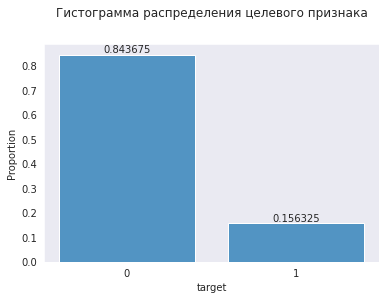

In [29]:
hist = sns.histplot(df['target'], shrink=.8, discrete=True, stat='proportion')
for bars in hist.containers:
        hist.bar_label(bars)
hist.set(xticks=df['target'].unique())
hist.set_title('Гистограмма распределения целевого признака', y=1.1);

Значения 'No' в 'end_date' поменяем на последнюю актуальную дату, и приведем к типу datetime

In [30]:
df['end_date'] = df['end_date'].apply(lambda x: x if x != 'No' else '2020-02-01')

In [31]:
df['end_date'] = pd.to_datetime(df['end_date'])

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float32       
 8   internet_service   7043 non-null   object        
 9   online_security    7043 non-null   object        
 10  online_backup      7043 non-null   object        
 11  device_protection  7043 non-null   object        
 12  tech_support       7043 non-null   object        
 13  streaming_tv       7043 non-null   object        
 14  streamin

Теперь можно добавить новый признак - количество месяцев в течении которых клиент пользовался услугами, или продолжает пользоваться. Тут возникает некоторая проблема в том, что pandas убрал возможность использовать месяц в типе данных timedelta. Поэтому разделим разницу на среднее число дней в месяце.

In [33]:
df['period'] = round((df['end_date'] - df['begin_date']) / pd.Timedelta(days=30.44)).astype(int)

In [34]:
df['period']

0        1
1       34
2        4
3       45
4        5
        ..
7038    24
7039    72
7040    11
7041     7
7042    66
Name: period, Length: 7043, dtype: int64

## Графики

Выделим числовые признаки и категориальные.

In [35]:
num_cols = [
    'period',
    'monthly_charges',
    'total_charges',
]

cat_cols = [
    'type',
    'paperless_billing',
    'payment_method',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'multiple_lines'
]

Посмотрим на самые показательные гистограммы по разным признакам

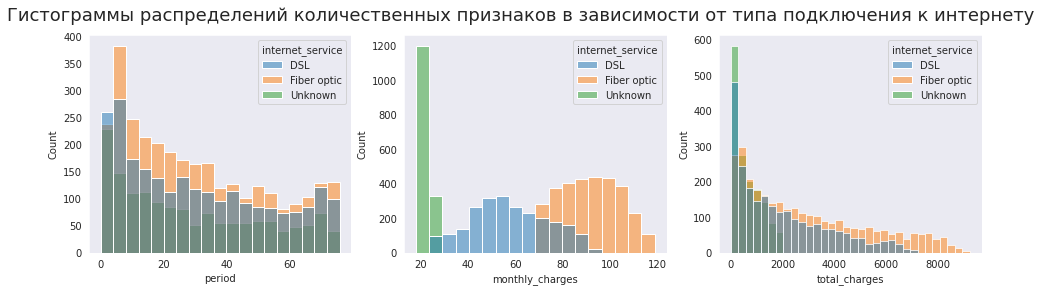

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, hue='internet_service', ax=ax[i])
    
fig.suptitle('Гистограммы распределений количественных признаков в зависимости от типа подключения к интернету', fontsize=18)
plt.show()

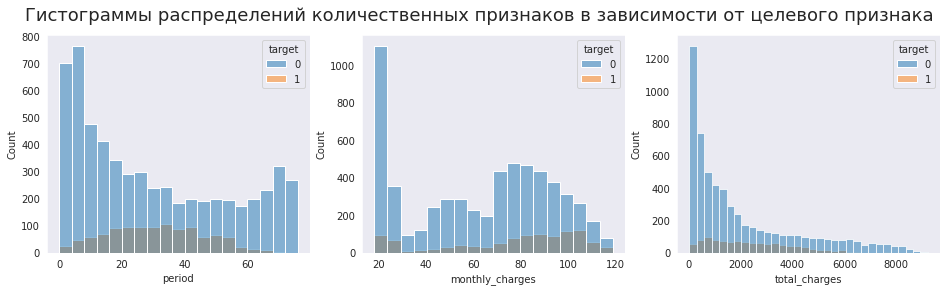

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, hue='target', ax=ax[i])

fig.suptitle('Гистограммы распределений количественных признаков в зависимости от целевого признака', fontsize=18)
plt.show()

Здесь мы видим, что сумма чека в месяц сильно зависит от типа подключения к интернету. Также видно, что перестают пользоваться услугами люди которые слишком много платят или слишком мало платят в месяц.

Еще видим, что уходят люди со средним периодом потребления услуг. Если человек в какой-то момент не разрывает контракт, то скорее всего он уже никогда не перейдет в другую компанию.

Посмотрим на категориальные графики

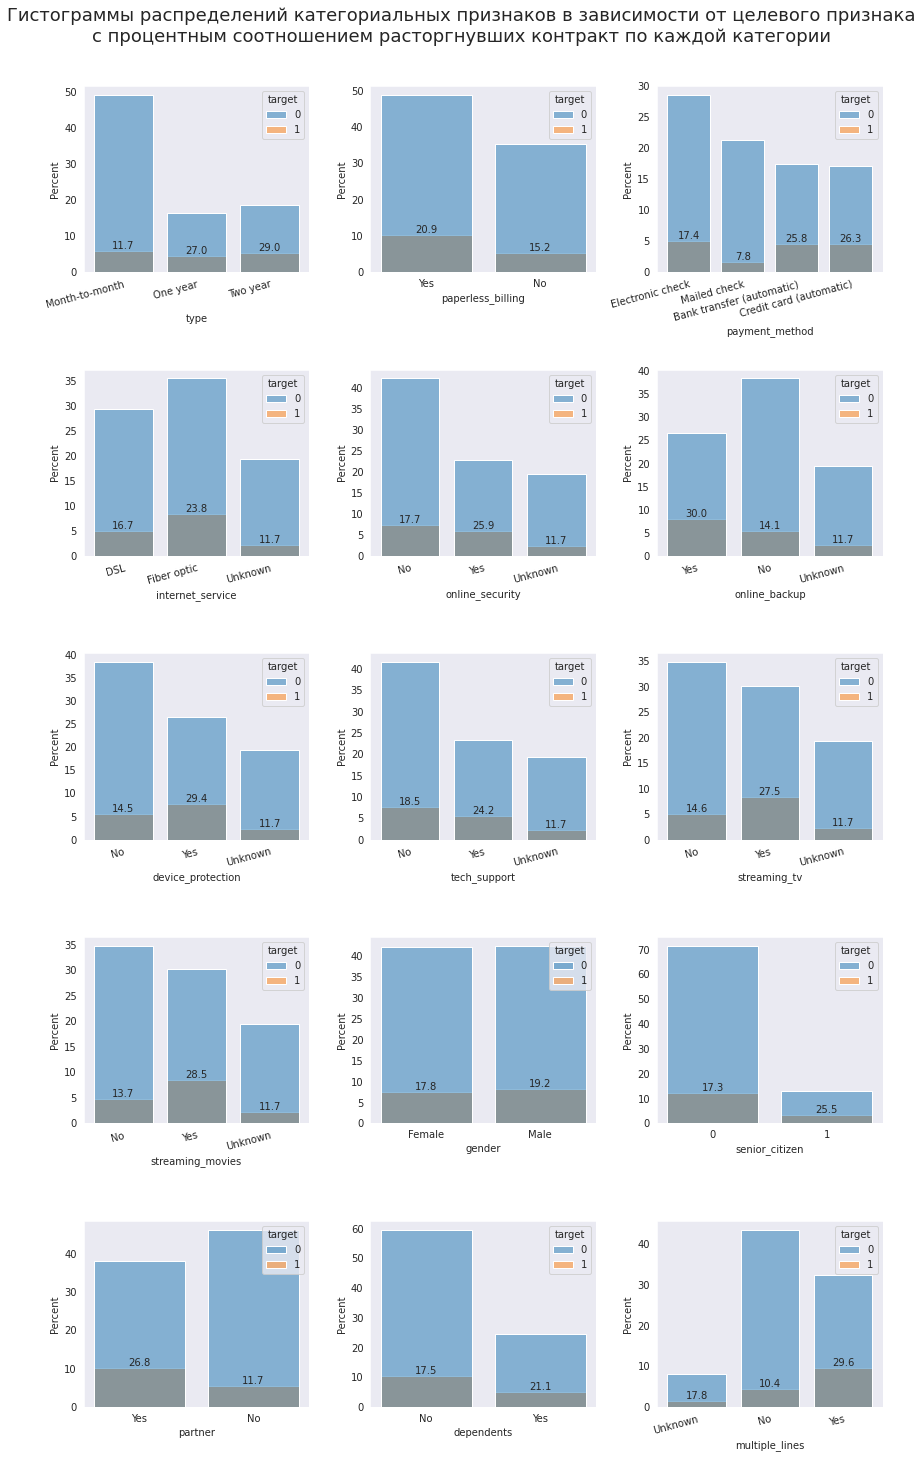

In [39]:
fig, ax = plt.subplots(5, 3, figsize=(12, 20))

ax = ax.ravel()

for i, col in enumerate(cat_cols):
    hist = sns.histplot(data=df, x=col, hue='target', ax=ax[i], shrink=.8, discrete=True, stat='percent')
    # for bars in hist.containers:
    #     hist.bar_label(bars, fmt='%.1f')
    percentage = (100 * hist.containers[0].datavalues / hist.containers[1].datavalues).round(1)
    hist.bar_label(hist.containers[0], percentage)
    hist.set_xticks(ticks=df[col].unique())
    if len(df[col].unique()) > 2:
        plt.setp(hist.get_xticklabels(), rotation=15, ha="right",
             rotation_mode="anchor")

fig.suptitle('Гистограммы распределений категориальных признаков в зависимости от целевого признака\nс процентным соотношением расторгнувших контракт по каждой категории', y=1.01, fontsize=18)
plt.tight_layout(h_pad=3, w_pad=1)

plt.show()

Выводы по графикам.

Кто чаще остается с компанией:
* Платит за услуги каждый месяц;
* Получает чек на email;
* Не имеет супруга(у).

Кто чаще уходит:
* Подключение к интернету через оптику;
* Имеет стриминговое ТВ;
* Имеет каталог фильмов;
* Много дополнительных сервисов (каждый влияет по разному);
* Многоканальный телефон.

А вот какого-то существенного влияния пола на распределение не замеченно.

# Построение моделей

## Новые признаки

Признаки которые удалось придумать:
- 'mean_charges' - средние траты человека в месяц за весь период;
- 'difference' - разница между тратами за весь период и расчитанными исходя из последних трат за месяц (уменьшил или увеличил клиент чек по оплате за последнее время);
- 'period_days' - период использования услуг в днях. Изначально расчитал в месяцах, но и в днях тоже стоит использовать.

Вычисляем 'mean_charges' как отношение 'total_charges' к 'period'

In [40]:
df['period'].min()

0

Поскольку минимальное значение периода ноль, то прибаваим к нему единицу

In [41]:
df['mean_charges'] = df['total_charges'] / (df['period'] + 1)
num_cols.append('mean_charges')

In [42]:
df['difference'] = df['monthly_charges'] * df['period'] - df['total_charges']
num_cols.append('difference')

In [43]:
df['period_days'] = (df['end_date'] - df['begin_date']).dt.days
num_cols.append('period_days')

In [44]:
df.nunique()

customer_id          7043
begin_date             77
end_date               67
type                    3
paperless_billing       2
payment_method          4
monthly_charges      1585
total_charges        6664
internet_service        3
online_security         3
online_backup           3
device_protection       3
tech_support            3
streaming_tv            3
streaming_movies        3
gender                  2
senior_citizen          2
partner                 2
dependents              2
multiple_lines          3
target                  2
period                 76
mean_charges         6788
difference           3584
period_days           251
dtype: int64

## Корреляция признаков

Посмотрим на корреляцию всех признаков используя phik

In [45]:
corr_matrix = df.drop(columns=['customer_id', 'begin_date', 'end_date']).phik_matrix(interval_cols=num_cols)

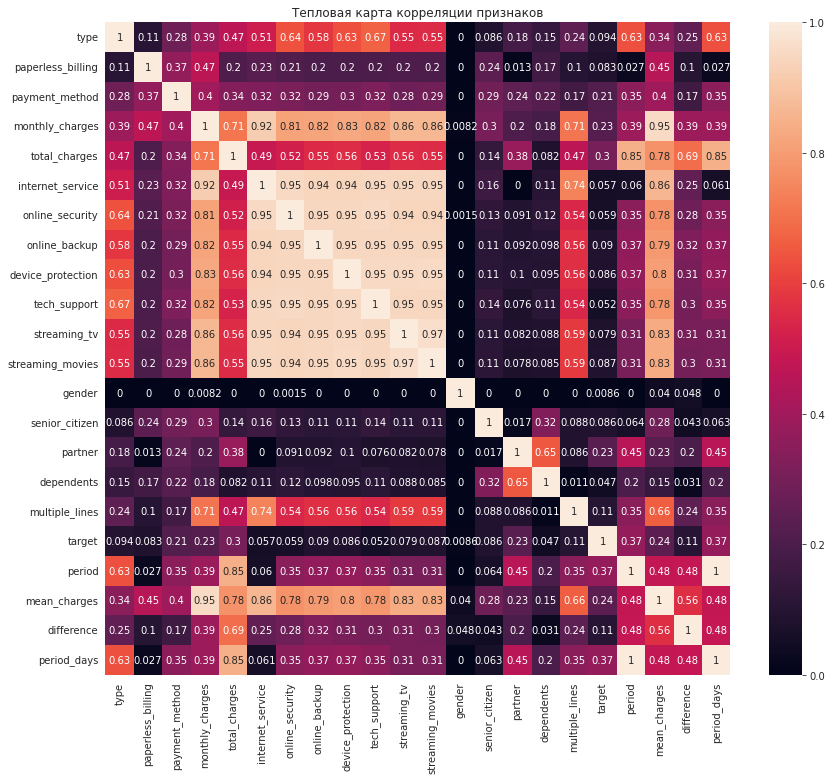

In [46]:
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True).set_title('Тепловая карта корреляции признаков');

Большая корреляция признаков `period` и `period_days` между собой. Опытным путем позднее выяснил, что лучше не использовать `period`. Также большая корреляция между `mean_charges` и `monthly_charges`. Не буду использовать новый признак. Это что касается новых признаков.

А вот в старых признаках сильно коррелируют между собой все интернет услуги. Оставлю только `internet_service`. На графиках выше было видно четкое разделение на группы по этому признаку, процент ушедших был одинаковый во всех категориях.

Признак `gender` не имеет никакой корреляции ни с чем, в том числе и с таргетом. Удалю его.

In [47]:
num_cols

['period',
 'monthly_charges',
 'total_charges',
 'mean_charges',
 'difference',
 'period_days']

In [48]:
num_cols = num_cols[1:3] + num_cols[-2:]
num_cols

['monthly_charges', 'total_charges', 'difference', 'period_days']

In [49]:
cat_cols

['type',
 'paperless_billing',
 'payment_method',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'multiple_lines']

In [50]:
cat_cols = cat_cols[:4] + cat_cols[11:]
cat_cols

['type',
 'paperless_billing',
 'payment_method',
 'internet_service',
 'senior_citizen',
 'partner',
 'dependents',
 'multiple_lines']

## Разделение на выборки

Разделим на выборки с учетом баланса классов

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df[num_cols + cat_cols], df['target'], test_size=0.25, stratify=df['target'], random_state=RANDOM_STATE)

Пайплайн для обучения моделей из sklearn

In [52]:
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="error", drop='first')),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

## RandomForestClassifier

Посмотрим для начала на RandomForestClassifier()

In [53]:
forest = GridSearchCV(
    Pipeline(steps=[("preprocessor", preprocessor), ("clf", RandomForestClassifier(random_state=RANDOM_STATE))]), 
    param_grid={
        'clf__n_estimators': [500, 1000, 1500],
        'clf__criterion': ['gini', 'entropy']
    },
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

In [54]:
forest.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'difference',
                                                                          'period_days']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          

In [55]:
forest.best_params_

{'clf__criterion': 'entropy', 'clf__n_estimators': 1500}

In [56]:
forest.best_score_

0.8144268068966886

Не сильно большая метрика, но и не самая плохая. Посмотрим теперь на GradientBoostingClassifier()

## GradientBoostingClassifier

In [57]:
gbc = GridSearchCV(
    Pipeline(steps=[("preprocessor", preprocessor), ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))]), 
    param_grid={
        'clf__n_estimators': [500, 1000],
        'clf__loss': ['exponential'],
        'clf__learning_rate': [0.05, 0.1, 0.5]
    },
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

In [58]:
gbc.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'difference',
                                                                          'period_days']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          

In [59]:
gbc.best_params_

{'clf__learning_rate': 0.5,
 'clf__loss': 'exponential',
 'clf__n_estimators': 1000}

In [60]:
gbc.best_score_

0.887396827399512

Оценка с которой можно уже заканчивать проект. Но посмотрим еще на CatBoost

## CatBoost

In [62]:
train_data = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_cols
)

test_data = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_cols
)

Подберем гиперпараметры через встроенный GridSearch

In [78]:
cat_model = CatBoostClassifier(
    n_estimators=3000,
    loss_function='Logloss',
    verbose=False,
    eval_metric='AUC:hints=skip_train~false',
    one_hot_max_size=3,
    random_seed=RANDOM_STATE
    )

grid_search_result = cat_model.grid_search({
    'l2_leaf_reg': np.linspace(0.05, 0.35, 13),
    'learning_rate': [0.05, 0.06],
    },
    train_data,
    cv=3,
    partition_random_seed=RANDOM_STATE,
    verbose=False,
    refit=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.9201102536
bestIteration = 1585


bestTest = 0.9197500919
bestIteration = 2727


bestTest = 0.9209996325
bestIteration = 1463


bestTest = 0.9219404631
bestIteration = 1572


bestTest = 0.9174421169
bestIteration = 2284


bestTest = 0.9225652334
bestIteration = 1911


bestTest = 0.9227048879
bestIteration = 1248


bestTest = 0.9194634326
bestIteration = 1976


bestTest = 0.9172436604
bestIteration = 1666


bestTest = 0.9199338479
bestIteration = 1334


bestTest = 0.9160382212
bestIteration = 2923


bestTest = 0.9163763322
bestIteration = 2398


bestTest = 0.91815509
bestIteration = 2402


bestTest = 0.920492466
bestIteration = 1960


bestTest = 0.9148327821
bestIteration = 2193


bestTest = 0.9176846748
bestIteration = 2037


bestTest = 0.9190812201
bestIteration = 1728


bestTest = 0.9133186329
bestIteration = 1489


bestTest = 0.9161705255
bestIteration = 2573


bestTest = 0.9147004778
bestIteration = 2624


bestTest = 0.9186916575
bestIteration = 2706


bestTest = 0.91

Теперь посмотрим на оценку ROC_AUC на кроссвалидации

In [80]:
params = cat_model.get_params()

scores = cv(
    train_data,
    params,
    plot="True",
)

print(np.max(scores['test-AUC-mean']))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8859427117
bestIteration = 2981

Training on fold [1/3]

bestTest = 0.892634221
bestIteration = 2021

Training on fold [2/3]

bestTest = 0.8924322008
bestIteration = 2921

0.8900287452471066


ROC_AUC = 0.89 - это максимальная оценка среди всех моделей. Выбираем эту модель и смотрим что получается на тесте.

## Лучшая модель

Параметры модели

In [81]:
cat_model.get_params()

{'loss_function': 'Logloss',
 'random_seed': 220523,
 'verbose': False,
 'one_hot_max_size': 3,
 'eval_metric': 'AUC:hints=skip_train~false',
 'n_estimators': 3000,
 'learning_rate': 0.05,
 'l2_leaf_reg': 0.125}

Оценка ROC_AUC на тесте

In [82]:
roc_auc = roc_auc_score(y_test, cat_model.predict_proba(X_test)[:, 1])
roc_auc

0.9127395081365471

Отличная оценка. Посмотрим на график кривой

In [83]:
curve = get_roc_curve(cat_model, test_data)

In [84]:
(fpr, tpr, thresholds) = curve

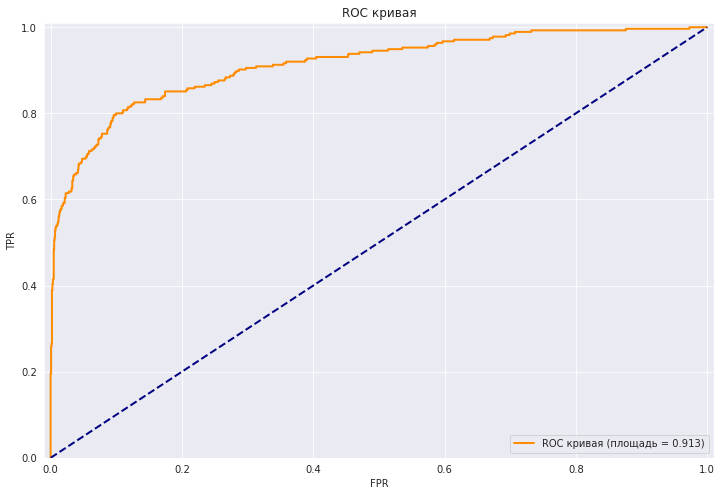

In [85]:
plt.figure(figsize=(12, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC кривая (площадь = {roc_auc:.3})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([0.0, 1.01])
plt.grid(True)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC кривая')
plt.legend(loc='lower right')
plt.show()

И отдельно на графики FPR и FNR

In [86]:
(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

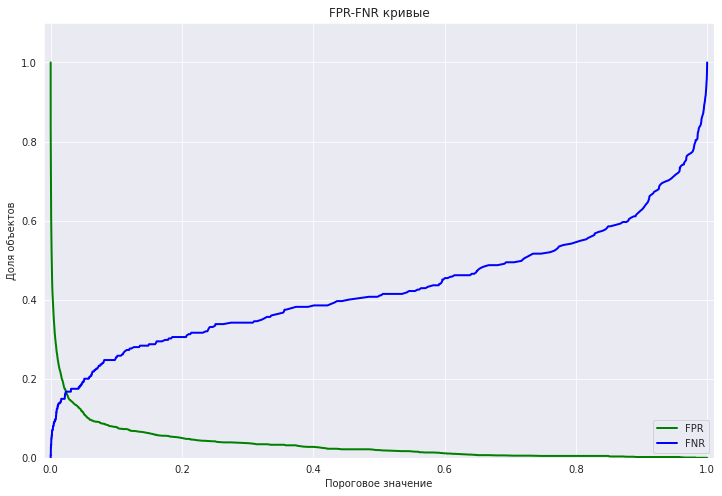

In [87]:
plt.figure(figsize=(12, 8))
lw = 2

plt.plot(thresholds, fpr, color='green', lw=lw, label='FPR')
plt.plot(thresholds, fnr, color='blue', lw=lw, label='FNR')
plt.xlim([-0.01, 1.01])
plt.ylim([0.0, 1.1])
plt.grid(True)
plt.xlabel('Пороговое значение')
plt.ylabel('Доля объектов')
plt.title('FPR-FNR кривые')
plt.legend(loc='lower right')
plt.show()

Посмотрим на матрицу ошибок

In [88]:
cm = confusion_matrix(y_test, cat_model.predict(X_test))

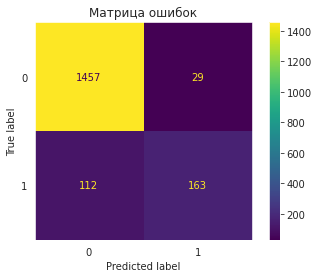

In [89]:
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.title('Матрица ошибок')
plt.show()

Модель достаточно редко ошибается в том, что клиент останется. Но почти в половине случаев ошибается с тем, кто вероятнее всего уйдет.

Если бизнесу важнее узнать кто действительно покинет компанию, то можно изменить пороговое значение, например, на 0.8. Тогда доля ложныйх срабатываний сильно сократится.

Для примера посмотрим пороговые значения при которых доля ложноотрицательных срабатываний и доля ложноположительных срабатываний сократяться до 1 %

In [90]:
print(select_threshold(model=cat_model, data=test_data, FNR=0.01))
print(select_threshold(model=cat_model, data=test_data, FPR=0.01))

0.00021976336210481292
0.621596918946629


Перейдем к важности признаков, и посмотрим все на графике

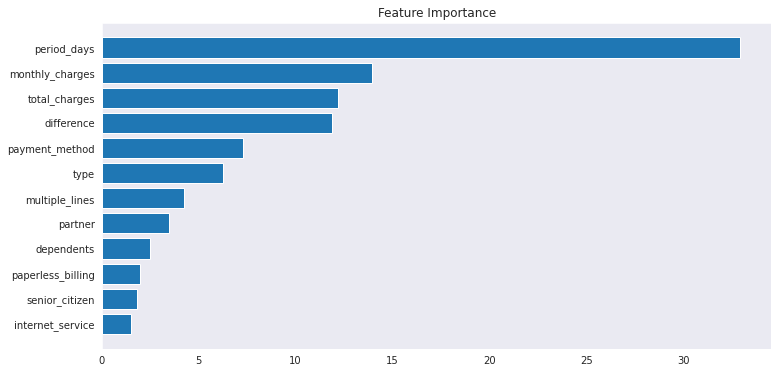

In [91]:
feature_importance = cat_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

Все мои дополнительные признаки оказались в топе. Самыми же важными признакоми оказались - время которое клиент пользуется услугами компании и общее количество потраченных денег. Некоторое значительное влияние оказывает то, как человек оплачивает услуги.

# Общий вывод

Рассмотрены данные оператора связи «Ниединогоразрыва.ком»:
- Данные объеденены из разных таблиц по разным видам услуг;
- Выявленны пропуски в данных общих трат у новых клиентов;
- Сгенерированны новые признакми на основе даты, и количества потраченных денег;
- Исследован баланс классов;
- Данные разделены на тестовую и обучающую выборки.

Обучено несколько моделей для прогнозирования оттока клиентов. Лучше всего себя показала модель `CatBoostClassifier` со следующими параметрами:
```python
{'loss_function': 'Logloss',
 'random_seed': 220523,
 'verbose': False,
 'one_hot_max_size': 3,
 'eval_metric': 'AUC:hints=skip_train~false',
 'n_estimators': 3000,
 'learning_rate': 0.05,
 'l2_leaf_reg': 0.125}
```
ROC_AUC на тестовой выборке 0.913, я думаю заказчик должен быть доволен )